# Bird Simulation Evaluation Script

## Imports & Preparations

In [2]:
import numpy as np
import birds
import argparse
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection
from IPython.display import HTML
%matplotlib inline

In [3]:
v = 0.03
n = 100
rho = 4
L = np.sqrt(n/rho)
r = 1
eta = 5

scalefactor = 100


birds.width = int(L*scalefactor)
birds.height = int(L*scalefactor)
birds.n = n

# arguments in Namespace-Format for Flock().__init__()
args = argparse.Namespace()
args.angle = 0
args.limit_view = "alignment"
args.max_velocity = v*scalefactor
args.min_velocity = v*scalefactor
args.v = None
args.max_acceleration = 0.03
args.random = 0.
args.eta = 0
args.alignment_radius = r*scalefactor
args.cohesion_radius = 50
args.separation_radius = 25
args.alignment = 1
args.cohesion = 0
args.separation = 0


## Run with these Settings

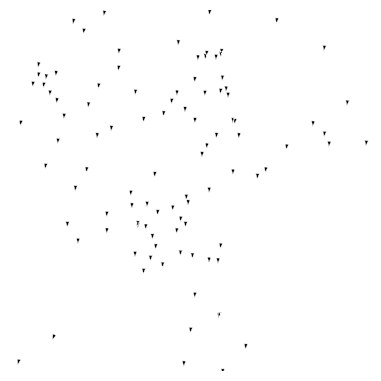

In [11]:
frames = 1000
birds.param_record = False
birds.trace = None
birds.flock = birds.Flock(args)
fig = plt.figure(figsize=(5, 5*birds.height/birds.width), facecolor="white")
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], aspect=1, frameon=False)
birds.collection = birds.MarkerCollection(birds.n)
ax.add_collection(birds.collection._collection)
ax.set_xlim(0, birds.width)
ax.set_ylim(0, birds.height)
ax.set_xticks([])
ax.set_yticks([])

animation = FuncAnimation(fig, birds.update, interval=10, frames=frames)
HTML(animation.to_html5_video())


## Find moving phase

In [59]:
args.eta = 0
f = birds.Flock(args)
t = 0
while f.get_va() < 0.99:
    f.run()
    t += 1
print("v_a: "+str(f.get_va())+" at t: "+str(t))

v_a: 0.99053255717 at t: 307


In [60]:
fs = []
for i in range(10):
    fs.append(birds.Flock(args))
for f in fs:
    for t in range(500):
        f.run()
for f in fs:
    print(str(f.get_va()))

0.268352349599
0.594581476847
0.589640617371
0.999999936422
0.999999936422
1.0
1.0
0.999999936422
0.999999936422
0.049135740598


## Run with varying Eta

Flock 0 at eta=0.0 done. v_a=0.333333299425
Flock 1 at eta=0.555555555556 done. v_a=0.333333299425
Flock 2 at eta=1.11111111111 done. v_a=0.333333333333
Flock 3 at eta=1.66666666667 done. v_a=0.333332214355
Flock 4 at eta=2.22222222222 done. v_a=0.332562866211
Flock 5 at eta=2.77777777778 done. v_a=0.329091661241
Flock 6 at eta=3.33333333333 done. v_a=0.333333367242
Flock 7 at eta=3.88888888889 done. v_a=0.333321092394
Flock 8 at eta=4.44444444444 done. v_a=0.333333265516
Flock 9 at eta=5.0 done. v_a=0.33333340115


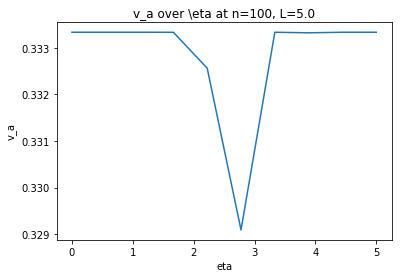

In [7]:
res = 10
time = range(1000)
repeat = 3
eta = np.linspace(0.,5.,res)


va = np.empty(res)
vas = np.empty(repeat)
for i,args.eta in enumerate(eta):
    for j in range(repeat):
        f = birds.Flock(args)
        for t in time:
            f.run()
        vas[j] = f.get_va()
    va[i] = vas[j].sum()/repeat
    print("Flock "+str(i)+" at eta="+str(args.eta)+" done. v_a="+str(va[i]))
plt.plot(eta,va)
plt.xlabel("eta")
plt.ylabel("v_a")
plt.title("v_a over \eta at n="+str(n)+", L="+str(L))